# Import Data into Colab

### From Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# # replace 'MyDrive' with your drive name
# %cd gdrive/MyDrive

### Or Clone from git repository

In [ ]:
!git clone -b development https://github.com/JayReigns/Detection-of-Rice-and-Potato-Plant-Disease.git

Cloning into 'Detection-of-Rice-and-Potato-Plant-Disease'...
remote: Enumerating objects: 7159, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 7159 (delta 6), reused 11 (delta 3), pack-reused 7142
Receiving objects: 100% (7159/7159), 313.56 MiB | 37.65 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (8215/8215), done.


### Change Working Directory

In [ ]:
%cd Detection-of-Rice-and-Potato-Plant-Disease

/content/Detection-of-Rice-and-Potato-Plant-Disease


### Install Modules

In [ ]:
# !pip install tensorflow
# !pip install matplotlib
# !pip install h5py

# Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks
import matplotlib.pyplot as plt
import numpy as np

# Load Dataset

### Load Images

`dataset` contains multiple `(image_batch, label_batch)` tuples.

Each `image_batch` contains 32 [batch_size] Images of size 256x256x3 [width, height, channels(rgb)].

Each `label_batch` contains class_name indices of corresponding image batch

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory  = "images",    # path
    color_mode = 'rgb',       # grayscale, rgb, rgba
    batch_size = 32,
    image_size = (256, 256),  # height, width
    shuffle    = True,
    seed       = None,
    crop_to_aspect_ratio = False,
)

Found 8204 files belonging to 8 classes.


Types of Classes

In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice_Blast',
 'Rice_Brown_spot',
 'Rice_Leaf_smut',
 'Rice_Tungro',
 'Rice__Bacterial_blight']

Taking a Sample Batch from Dataset

In [ ]:
sample_batch = dataset.take(1)

Dimensions of `image_batch`, `label_batch`

In [ ]:
for image_batch, label_batch in sample_batch:
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 6 0 3 7 7 3 3 3 3 4 1 0 3 1 7 1 1 0 7 1 0 4 4 3 7 6 6 6 3 0 4]


Displaying images of `sample_batch`

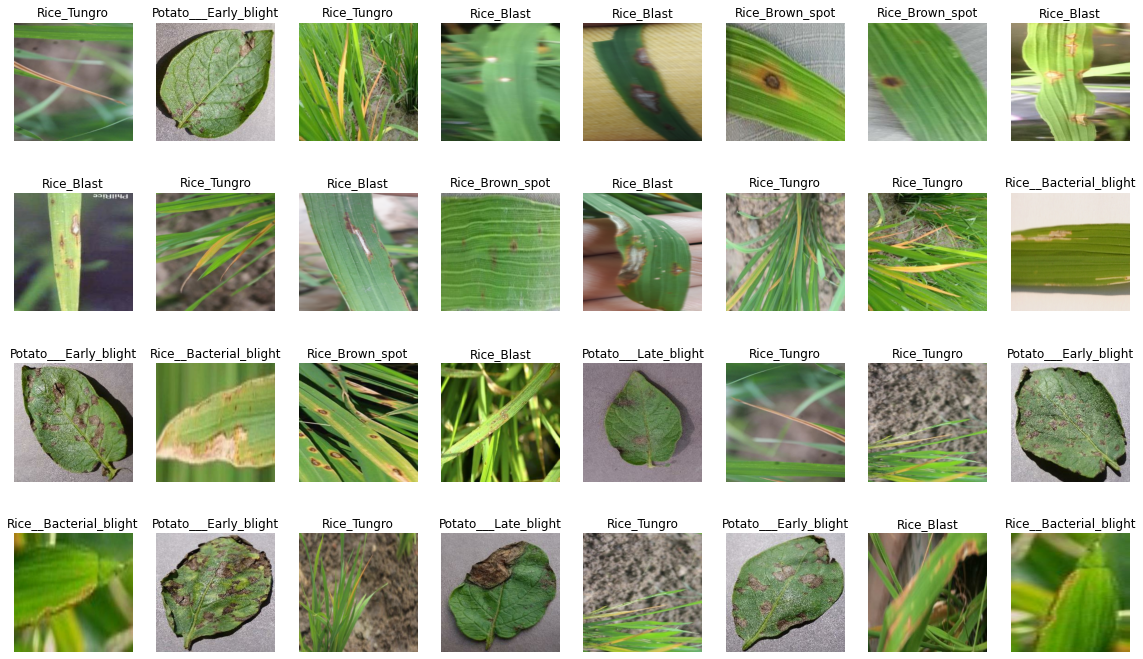

In [ ]:
plt.figure(figsize=(20, 12))
for image_batch, label_batch in sample_batch:
    size = len(image_batch)
    columns = 8
    rows = size//columns
    for i in range(size):
        ax = plt.subplot(rows, columns, i + 1)   # rows, cols, idx
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))   # converting float to int
        plt.axis("off")

# Split Dataset into Categories: train, validation, test
`train_ds` and `val_ds` is used during training.

`test_ds` is used to test the trained model

In [ ]:
def split_dataset(ds, ratios=(8, 1, 1,)):
    total = sum(ratios)
    ds_size = len(ds)
    skip = 0
    for ratio in ratios[:-1]:
        size = int(ds_size * ratio/total)
        yield ds.skip(skip).take(size)
        skip += size
    yield ds.skip(skip)

train_ds, val_ds, test_ds = split_dataset(dataset, (240, 16, 1))

# ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Total:", len(dataset))
print("Train:", len(train_ds))
print("Valid:", len(val_ds))
print("Test :", len(test_ds))

Total: 257
Train: 240
Valid: 16
Test : 1


# Model Creation

In [ ]:
for image_batch, label_batch in sample_batch:
    input_shape = image_batch.shape

model = models.Sequential([

    # preprocessing
    layers.experimental.preprocessing.Resizing(256, 256),   # resize images
    layers.experimental.preprocessing.Rescaling(1./255),    # normalize
    
    # data augmentation
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=None),
    layers.experimental.preprocessing.RandomRotation(0.5, seed=None),
    layers.RandomContrast(0.3, seed=None),
    layers.RandomZoom(0.3, seed=None),
    
    # layering
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # flatten
    layers.Flatten(),
    
    # dense layer
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

### Model Summary

In [ ]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 256, 256, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 256, 256, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 256, 256, 3)       0

### Model Compilation

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training

In [ ]:
keras_callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001),
    #   callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
]

`epochs` : Number of epochs to train the model.

Higher `epochs` increases accuracy.

In [ ]:
history = model.fit(
    train_ds,
    validation_data  = val_ds,
    validation_split = 0.0,     # validation_data gets priority
    batch_size       = None,    # defaults to 32
    verbose          = 'auto',  # 0=silent, 1=progress bar, 2=one line per epoch
    epochs           = 10,
    callbacks        = keras_callbacks
)

Epoch 1/10


240/240 [==============================] - 105s 362ms/step - loss: 1.4897 - accuracy: 0.4074 - val_loss: 0.9329 - val_accuracy: 0.6934
Epoch 2/10
240/240 [==============================] - 87s 363ms/step - loss: 0.8959 - accuracy: 0.6751 - val_loss: 0.5582 - val_accuracy: 0.8047
Epoch 3/10
240/240 [==============================] - 88s 366ms/step - loss: 0.6369 - accuracy: 0.7643 - val_loss: 0.4769 - val_accuracy: 0.7910
Epoch 4/10
240/240 [==============================] - 88s 364ms/step - loss: 0.4921 - accuracy: 0.8129 - val_loss: 0.3358 - val_accuracy: 0.8848
Epoch 5/10
240/240 [==============================] - 98s 408ms/step - loss: 0.4190 - accuracy: 0.8460 - val_loss: 0.2887 - val_accuracy: 0.8906
Epoch 6/10
240/240 [==============================] - 98s 407ms/step - loss: 0.3525 - accuracy: 0.8716 - val_loss: 0.4073 - val_accuracy: 0.8516
Epoch 7/10
240/240 [==============================] - 89s 367ms/step - loss: 0.3077 - accuracy: 0.8906 - val_loss: 0.2515 - val_accuracy: 0.

### Accuracy and Loss Graph

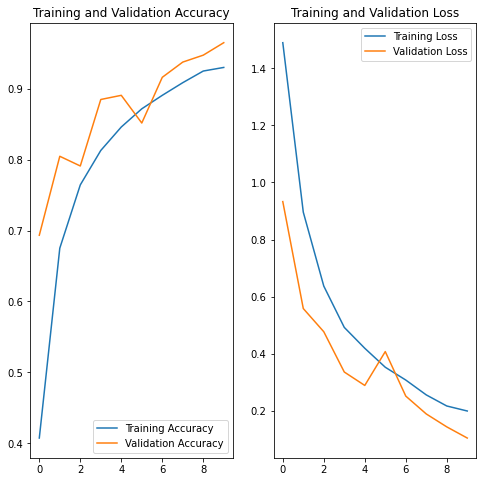

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

count = len(acc)    # no. of epochs

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(count), acc, label='Training Accuracy')
plt.plot(range(count), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(count), loss, label='Training Loss')
plt.plot(range(count), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing

### Performance on Test Dataset

In [ ]:
scores = model.evaluate(test_ds)    # tuple (loss, accuracy)

1/1 [==============================] - 11s 11s/step - loss: 0.2013 - accuracy: 1.0000


1/1 [==============================] - 0s 25ms/step


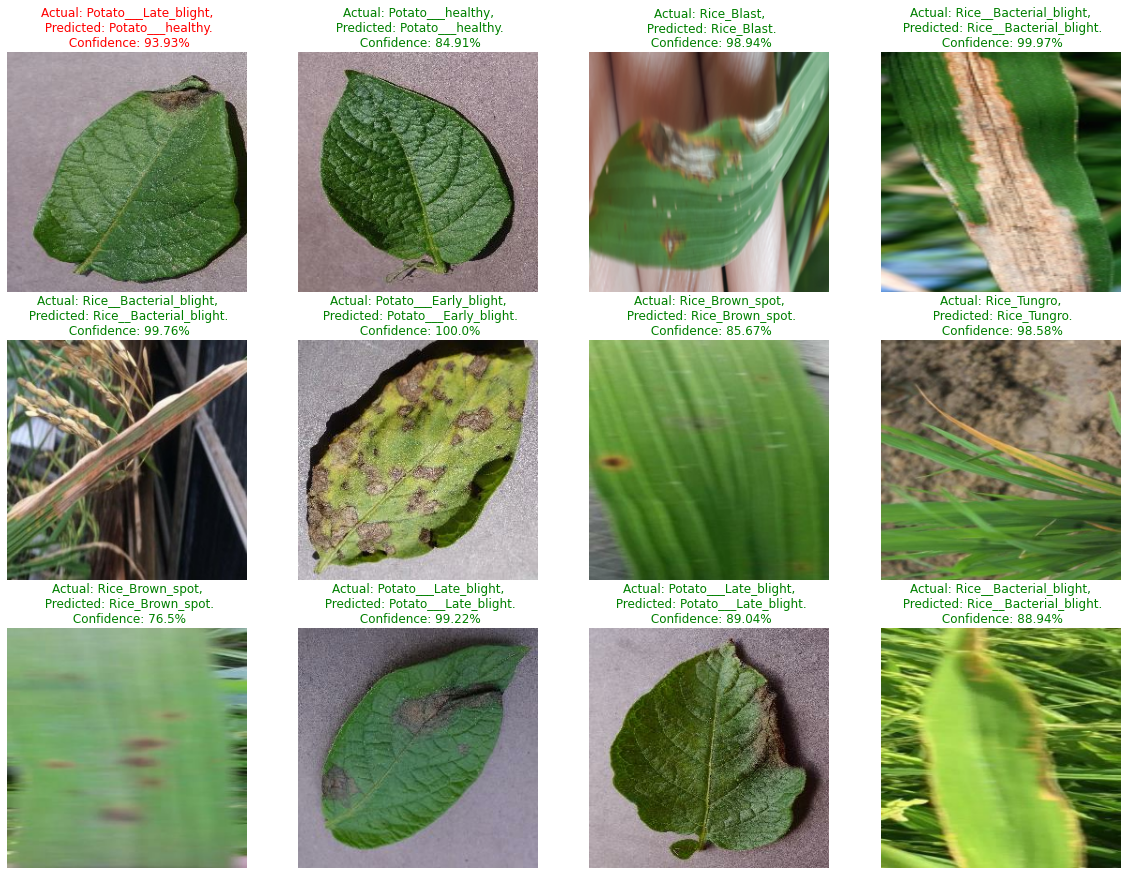

In [ ]:
plt.figure(figsize=(20, 20))

# take a batch from 'test_ds'
for image_batch, label_batch in test_ds.take(1):
    
    # returns array of confidences for different classes of all images in the batch
    prediction_batch = model.predict(image_batch)

    size = len(image_batch)
    columns = 4
    rows = size//columns
    
    for i in range(size):
        
        image = image_batch[i].numpy().astype("uint8")   # converting float to int
        
        actual_class    = class_names[label_batch[i]]
        predicted_class = class_names[np.argmax(prediction_batch[i])]
        confidence      = round(100 * (np.max(prediction_batch[i])), 2)
        
        ax = plt.subplot(rows, columns, i + 1)   # row, col, idx

        title = plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.setp(title, color= 'g' if actual_class == predicted_class else 'r')
        plt.imshow(image)
        plt.axis("off")

# Save Model

In [ ]:
import os, json, h5py
from datetime import datetime

MODEL_PATH = "models"
MODEL_NAME_FMT = "%Y%m%d_%H%M%S"

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

model_version = datetime.now().strftime(MODEL_NAME_FMT)
model_path = f"{MODEL_PATH}/{model_version}.h5"
model.save(model_path)

# writing class_names
with h5py.File(model_path,'r+') as fp:
  fp.attrs['class_names'] = json.dumps(class_names)

# Load Model

### Get the Latest Model

In [ ]:
import os

MODEL_PATH = "models"

def listmodels():
    for f in os.listdir(MODEL_PATH):
        # skip hidden files
        if f.startswith('.'):
            continue

        name, ext = f.rsplit('.', 1)

        # skip other files
        if ext != 'h5':
            continue
        
        # skip ill-formatted files
        try:
            int(name)
            yield name
        except:
            pass
        
try:
  model_version = max( listmodels(), key= int )
except:
    raise Exception("No Models Found!")

model_version

'20230322_153440'

### Load Model and Class Names

In [ ]:
import json, h5py

model_path = f"{MODEL_PATH}/{model_version}.h5"
model = tf.keras.models.load_model(model_path)

with h5py.File(model_path,'r') as fp:
    class_names = json.loads(fp.attrs.get('class_names'))

class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Rice_Blast',
 'Rice_Brown_spot',
 'Rice_Leaf_smut',
 'Rice_Tungro',
 'Rice__Bacterial_blight']

# Test a Single Image

In [ ]:
image_path = "images/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG"
image = tf.keras.utils.load_img(image_path)
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

1/1 [==============================] - 0s 266ms/step


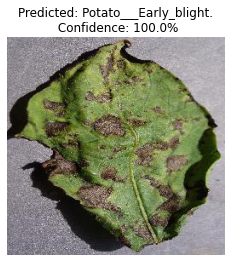

In [ ]:
predicted_class = class_names[np.argmax(predictions)]
confidence      = round(100 * (np.max(predictions)), 2)

plt.title(f"Predicted: {predicted_class}.\n Confidence: {confidence}%")
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
test_set = tf.keras.utils.image_dataset_from_directory(
    directory  = "/content/test images",    # path
    labels = None,
)

Found 7 files belonging to 1 classes.


In [ ]:
prd = model.predict(test_set)

1/1 [==============================] - 0s 299ms/step


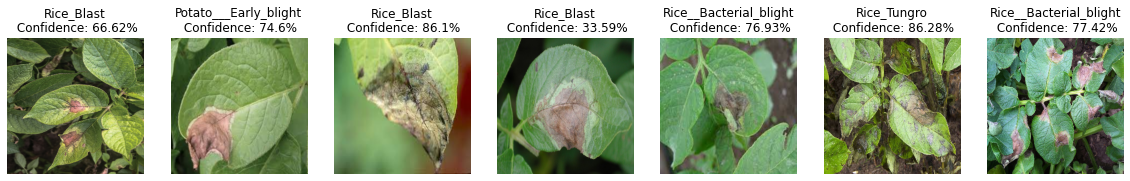

In [ ]:
plt.figure(figsize=(20, 30))
for image_batch in test_set.take(1):
    idx = 1
    for img, lb in zip(image_batch, prd):

        img = img.numpy().astype("uint8")   # converting float to int
        
        lbl    = class_names[np.argmax(lb)]
        conf      = round(100 * (np.max(lb)), 2)
        
        ax = plt.subplot(1, len(image_batch), idx)   # row, col, idx
        idx += 1

        plt.title(f"{lbl}\n Confidence: {conf}%")
        plt.imshow(img)
        plt.axis("off")